## Sentimental Tomatoes: Leveraging Feature Engineering and ML for Rotten Tomatoes Sentiment Prediction

### Introduction

We will be performing feature engineering and logistic regression/naive bayes ML models to predict sentiments of movie reviews.

The dataset is comprised of tab-separated files with sentences and phrases from the Rotten Tomatoes dataset. Phrases and sentences have been parsed by the Stanford parser, and each phrase and sentence have their own IDs. Multiple phrases can belong to the same sentence. Phrases that are repeated (which are typically short or common single words) are only included once in the each of the datasets.

Each phrase/sentence in the training data are labelled with one of the five sentiment scores:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

Our objective is to predict the sentiment of movie review sentences and phrases from the testing data with as much accuracy as possible.

Source: [https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/overview](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/overview)

### Load libraries and data

In [6]:
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from wordcloud import WordCloud
%matplotlib inline

# Preprocessing
import re
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
filepath = 'data/' # Path to training and testing data
train_data = pd.read_table(filepath + 'train.tsv')
test_data = pd.read_table(filepath + 'test.tsv')

In [9]:
train_data

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [10]:
test_data

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [11]:
train_data[train_data['Phrase'].isna()]

,PhraseId,SentenceId,Phrase,Sentiment


In [12]:
# There is a missing value for some reason...
test_data[test_data['Phrase'].isna()]

,PhraseId,SentenceId,Phrase
15519,171580,9213,NaN


In [13]:
test_data.at[15519, 'Phrase'] = "None" # This is what it's supposed to be
test_data.iloc[15519]

PhraseId      171580
SentenceId      9213
Phrase          None
Name: 15519, dtype: object

### Quick look at data

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [15]:
train_data['Sentiment'].unique()

array([1, 2, 3, 4, 0], dtype=int64)

<Axes: xlabel='Sentiment', ylabel='count'>

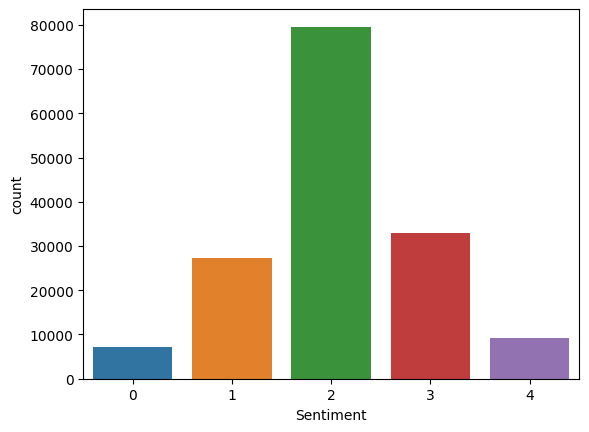

In [16]:
# Count of sentiment labels
sns.countplot(train_data, x='Sentiment')

In [17]:
# Get sentences only
# Luckily for us, the sentences always come before their derived phrases
train_sentences = train_data.drop_duplicates('SentenceId', keep='first')
train_sentences

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


<Axes: xlabel='Sentiment', ylabel='count'>

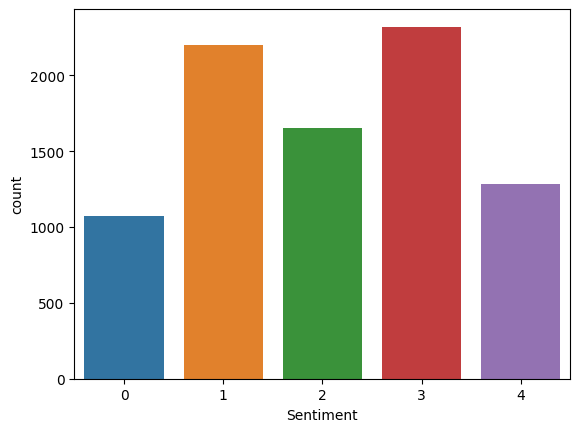

In [18]:
sns.countplot(train_sentences, x='Sentiment')

In [20]:
def show_wordcloud(words):
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='white', 
                          stopwords=stopwords.words('english')).generate(words)
    plt.figure(figsize=(10,6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

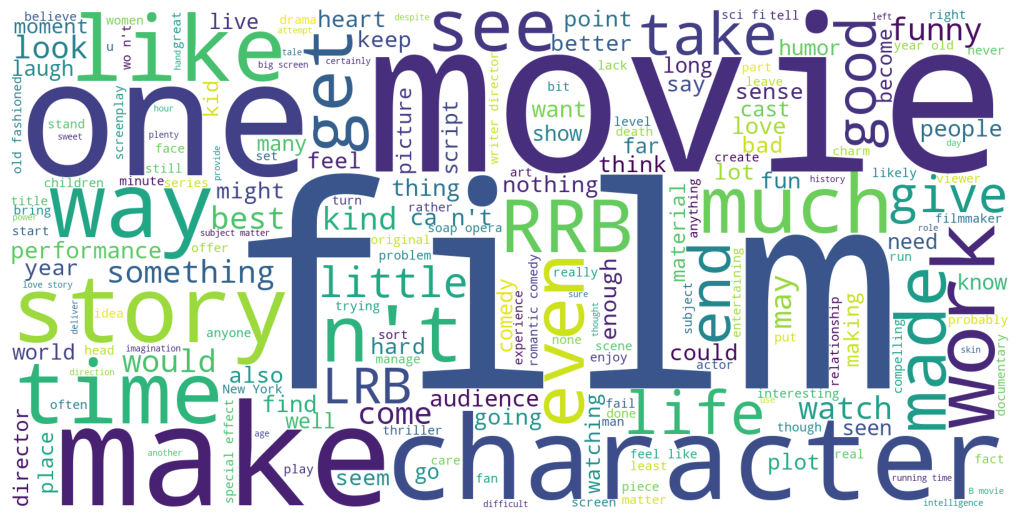

In [21]:
# Word cloud of all words in our training dataset
show_wordcloud(' '.join(train_data['Phrase']))

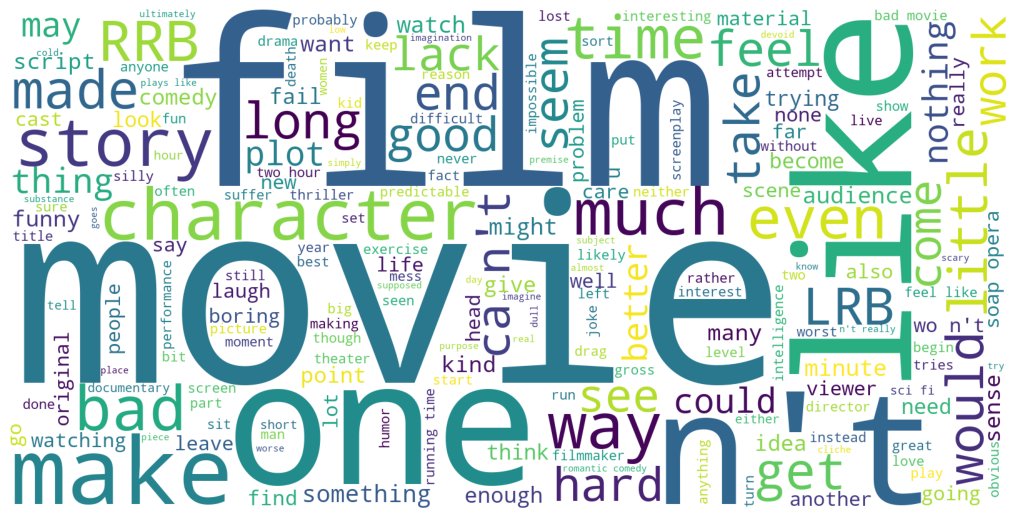

In [22]:
# Word cloud of words from phrases with a negative sentiment
show_wordcloud(' '.join(train_data[train_data['Sentiment'] < 2]['Phrase']))

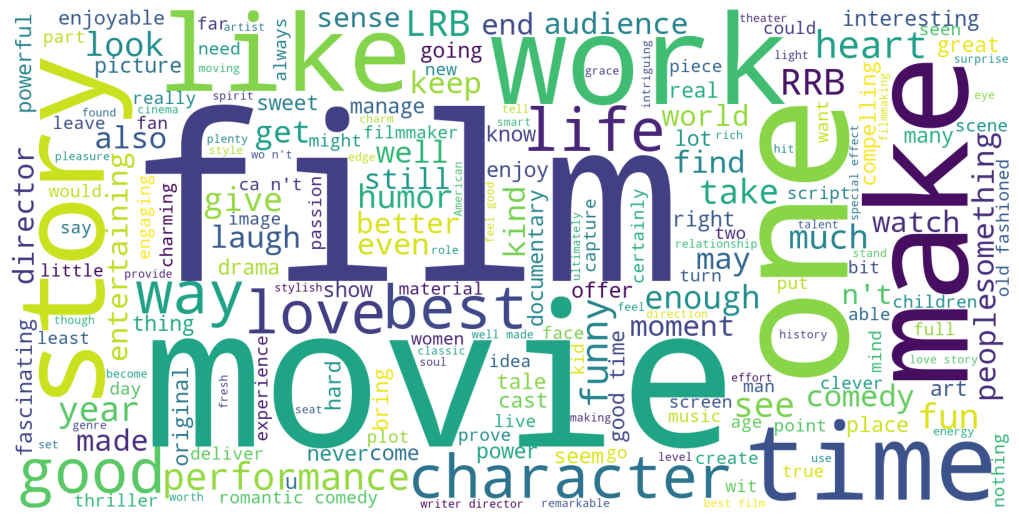

In [23]:
# Word cloud of words from phrases with a positive sentiment
show_wordcloud(' '.join(train_data[train_data['Sentiment'] > 2]['Phrase']))

### Feature engineering

#### Feature set 1: Term frequency–inverse document frequency (TF-IDF)

TF-IDF is a measure of how often a word appears in a document with inverse proportion to how often it appears across all documents in the corpus. That is, the TF-IDF value for a word in the document increases as it is used more frequently in the document, and decreases as it is used more frequently across all documents. In the context of our objective, every sentence (with unique sentence IDs) in our dataset is our corpus of documents. The intuition is that words that appear more often in a document and less often across all other documents are more significant.

The intuition is that negative, neutral, and positive words generally belong in phrases with their respective sentiments. Furthermore, it can detect the presence of words that might indicate negation (e.g., _not_ bad), sarcasm (e.g., _just_ great), and others.

In [24]:
def preprocess_phrase(phrase:str):
    # Leave only words
    # Also leave exclamation marks; they may or may not indicate intensity or sarcasm
    phrase =  re.sub('[^A-Za-z0-9!]+', ' ', phrase)

    # Make all letters lowercase
    phrase = phrase.lower()

    # Lemmatize
    wnl = WordNetLemmatizer()
    phrase = [wnl.lemmatize(word) for word in phrase.split()]

    # Remove stopwords
    stop_words = stopwords.words('english')
    phrase = [word for word in phrase if word not in stop_words]

    return ' '.join(phrase)

In [25]:
# Preprocess phrases
train_data['preprocessed_phrase'] = train_data['Phrase'].apply(preprocess_phrase)
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,preprocessed_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series


In [42]:
train_sentences = train_data.drop_duplicates('SentenceId', keep='first')
train_sentences.head()

,PhraseId,SentenceId,Phrase,Sentiment,preprocessed_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...
63,64,2,"This quiet , introspective and entertaining in...",4,quiet introspective entertaining independent w...
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,even fan ismail merchant work suspect would ha...
116,117,4,A positively thrilling combination of ethnogra...,3,positively thrilling combination ethnography i...
156,157,5,Aggressive self-glorification and a manipulati...,1,aggressive self glorification manipulative whi...


In [41]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_sentences['preprocessed_phrase']) # Fit vectorizer using only the unique sentences
train_tfidfFeatures = vectorizer.transform(train_data['preprocessed_phrase'])
train_tfidfFeatures

<156060x13666 sparse matrix of type '<class 'numpy.float64'>'
	with 626695 stored elements in Compressed Sparse Row format>

#### Feature set 2: Negative, neutral, and positive polarities

The polarity scores of a sentence are its negative, neutral, and positive sentiment strengths. We will be using NLTK's Sentiment Intensity Analyzer to calculate these scores.

Besides the obvious, the idea is that since negation, sarcasm, and the like have both negative and positive polarity in their grammar, the model may detect them if we introduce polarities as features.

In [43]:
# Get the negative, neutral, and positive sentiment intensity scores for each phrase
analyzer = SentimentIntensityAnalyzer()
train_polarityScores = train_data['Phrase'].apply(lambda phrase: analyzer.polarity_scores(phrase))

train_data['neg'] = train_polarityScores.apply(lambda scores: scores['neg'])
train_data['neu'] = train_polarityScores.apply(lambda scores: scores['neu'])
train_data['pos'] = train_polarityScores.apply(lambda scores: scores['pos'])

train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,preprocessed_phrase,neg,neu,pos
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...,0.0,0.843,0.157
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose,0.0,0.805,0.195
2,3,1,A series,2,series,0.0,1.000,0.000
3,4,1,A,2,,0.0,0.000,0.000
4,5,1,series,2,series,0.0,1.000,0.000


Text(0, 0.5, 'Negative polarity')

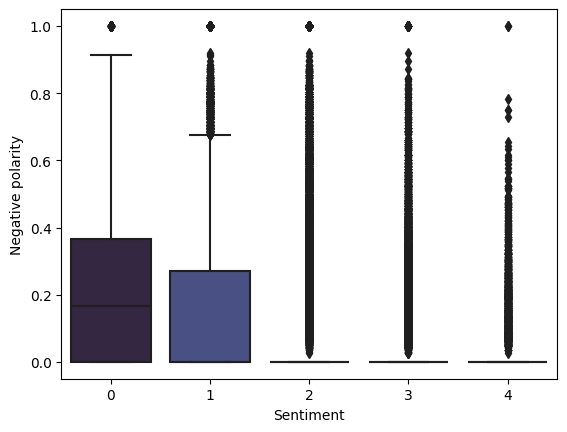

In [44]:
# Plot distribution of negative polarity scores
# Group by sentiments
sns.boxplot(train_data, x='Sentiment', y='neg', palette='mako')
plt.ylabel("Negative polarity")

Text(0, 0.5, 'Neutral polarity')

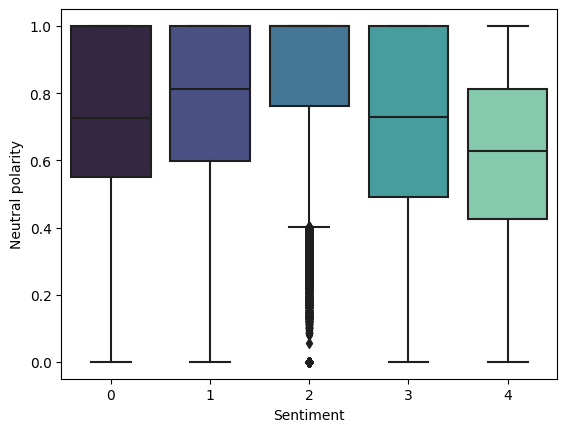

In [45]:
# Same as above, but with neutral polarity scores
sns.boxplot(train_data, x='Sentiment', y='neu', palette='mako')
plt.ylabel("Neutral polarity")

Text(0, 0.5, 'Positive polarity')

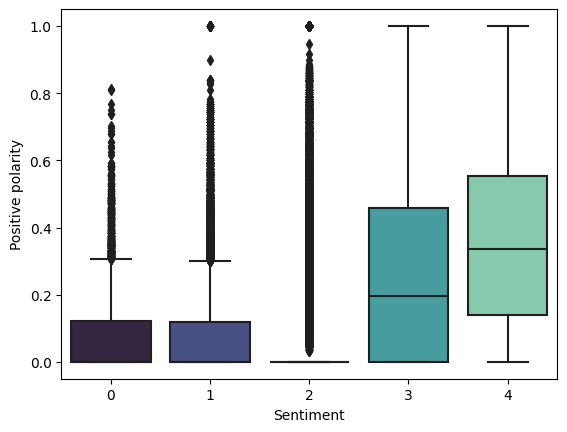

In [46]:
# Same as above, but with positive polarity scores
sns.boxplot(train_data, x='Sentiment', y='pos', palette='mako')
plt.ylabel("Positive polarity")

#### Feature set 3: Subjectivity

The subjectivity of a phrase is the amount of personal opinion rather than personal opinion contained in it. Supposedly, phrases expressing stronger opinions about movies would have more subjectivity. By that logic, a phrase with a sentiment value of 2 should be more likely to have a subjectivity value of 0, and phrases with sentiments values closer to 0 or 4 should be more likely to have a subjectivity value of 1.

In [47]:
# Get subjectivity scores for each phrase
train_data['subj'] = train_data['Phrase'].apply(lambda phrase: TextBlob(phrase).subjectivity)
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,preprocessed_phrase,neg,neu,pos,subj
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...,0.0,0.843,0.157,0.38125
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose,0.0,0.805,0.195,0.60000
2,3,1,A series,2,series,0.0,1.000,0.000,0.00000
3,4,1,A,2,,0.0,0.000,0.000,0.00000
4,5,1,series,2,series,0.0,1.000,0.000,0.00000


<Axes: xlabel='Sentiment', ylabel='subj'>

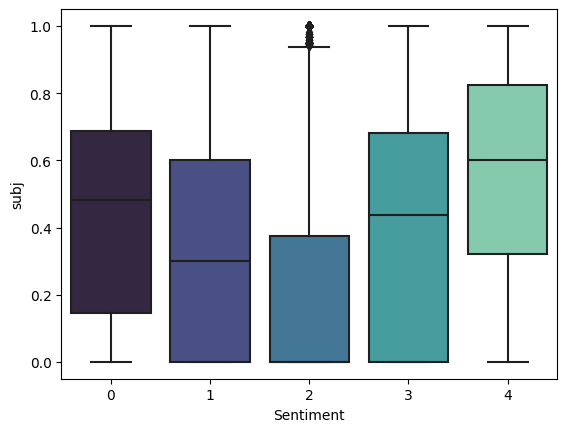

In [48]:
sns.boxplot(train_data, x='Sentiment', y='subj', palette='mako')

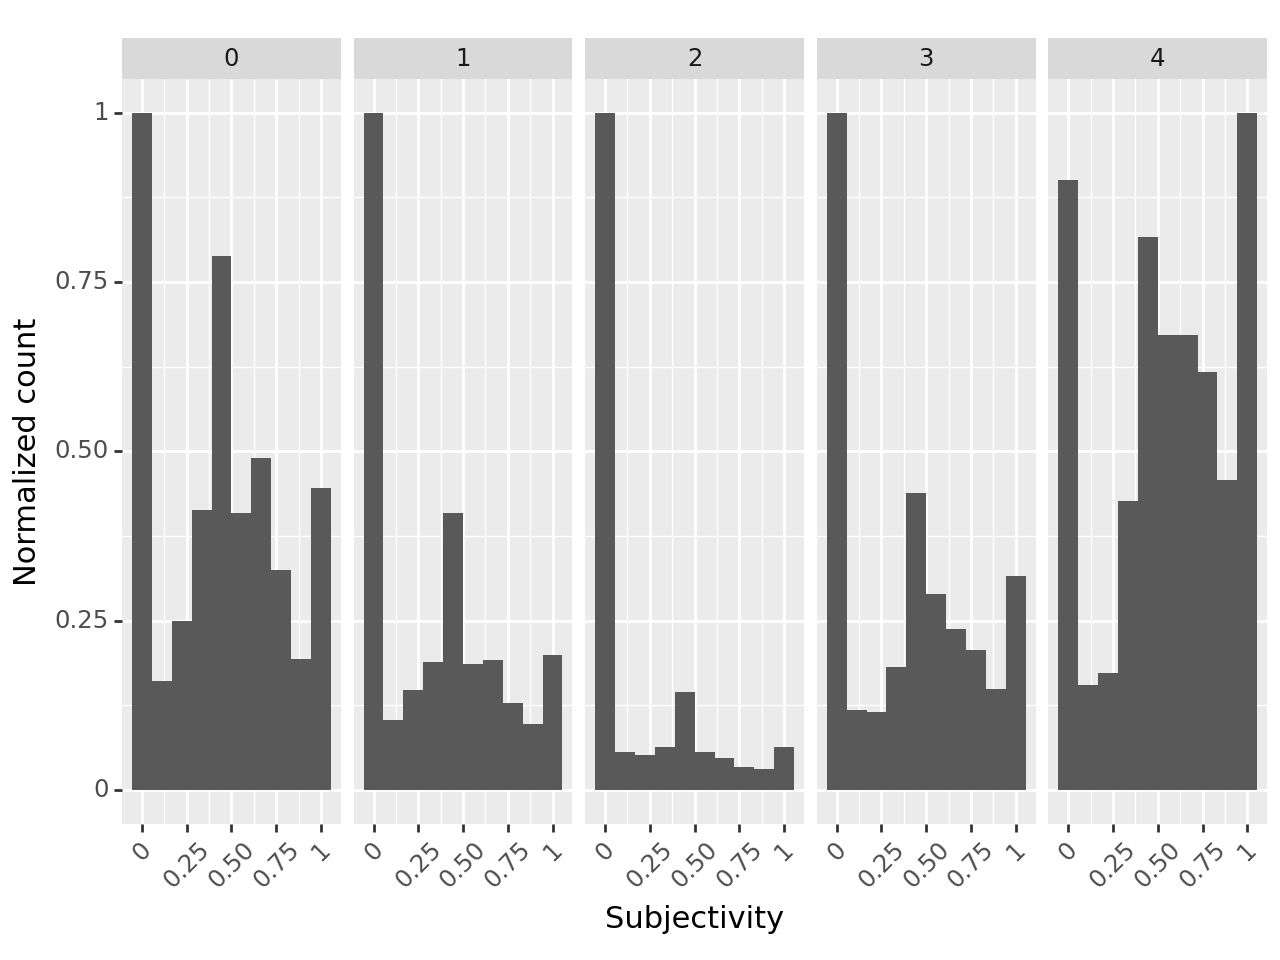

<Figure Size: (640 x 480)>

In [49]:
# Normalized distributions of subjectivity values
# Grouped by sentiment
p = p9.ggplot(data=train_data,
              mapping=p9.aes(x='subj', y=p9.after_stat('ncount'))) +\
p9.geom_histogram(bins=10) +\
p9.facet_wrap(facets='Sentiment', ncol=5) +\
p9.labs(x='Subjectivity', y='Normalized count') +\
p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=0.5))

p

C:\Users\17573\AppData\Roaming\Python\Python39\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 50'. Pick better value with 'binwidth'.


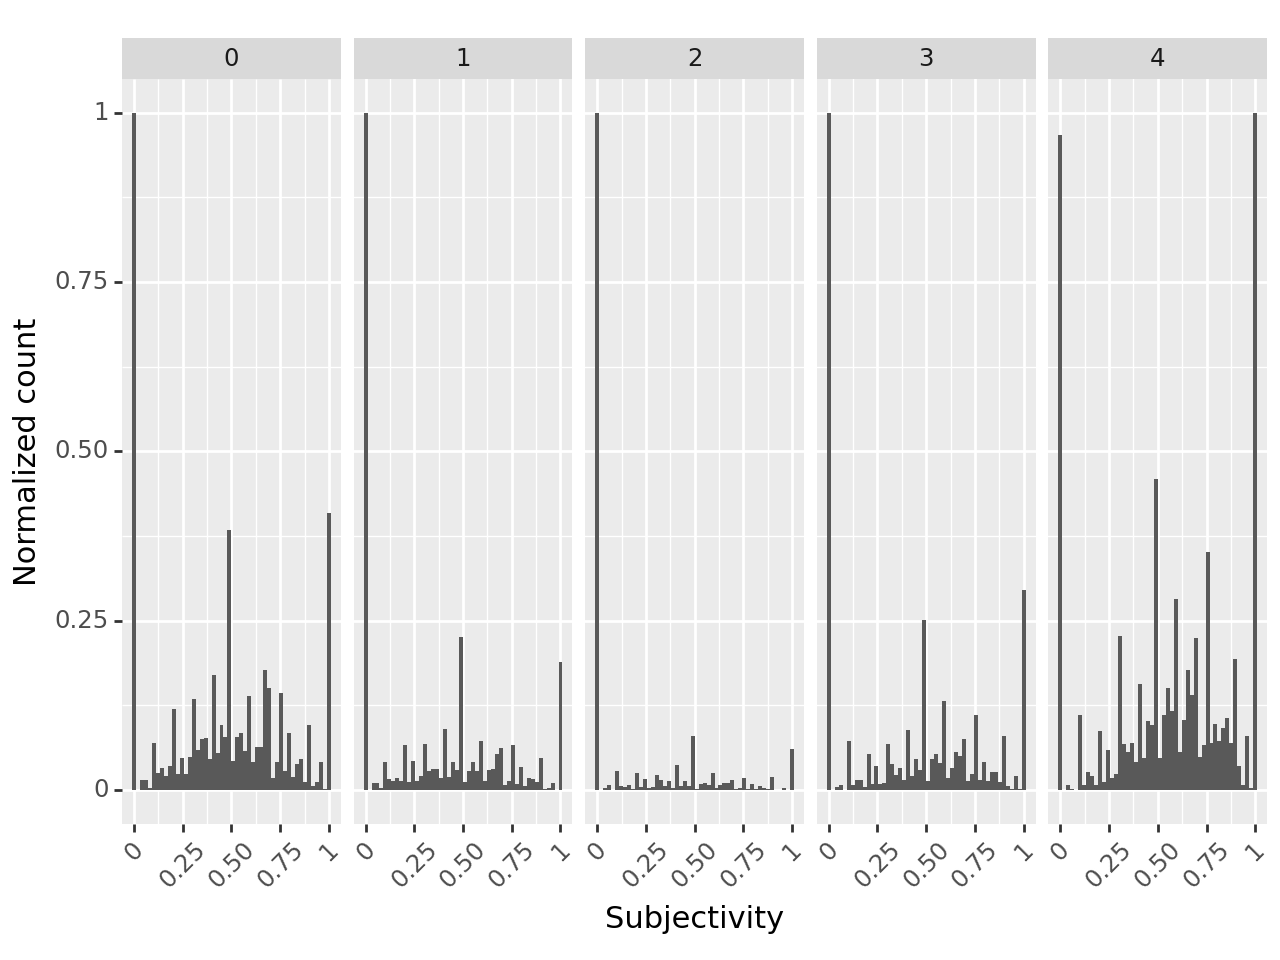

<Figure Size: (640 x 480)>

In [50]:
# Same as above, but with much smaller bins
p = p9.ggplot(data=train_data,
              mapping=p9.aes(x='subj', y=p9.after_stat('ncount'))) +\
p9.geom_histogram() +\
p9.facet_wrap(facets='Sentiment', ncol=5) +\
p9.labs(x='Subjectivity', y='Normalized count') +\
p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=0.5))

p

Key takeaways:
- Subjectivity of 0 is not a good predictor for sentiment
- Subjectivity of 1 is more common in sentiments closer to 0 and 4, *especially* in 4.
- Subjectivity closer to 0.5 is more common in sentiments closer to 0 and 4

#### Feature set 4: POS tag counts

Would certain parts of speech be used more often in phrases with certain sentiments? Here, we will be looking into adjectives, adverbs, and personal pronouns.

In [51]:
def count_pos(phrase:str, pos_list:list[str]) -> list[int]:
    # List of POS tags and their associated words
    tags = TextBlob(phrase).pos_tags

    # List of POS counts
    # Each POS will be in the order in which they are specified in pos_list
    pos_count = [0] * len(pos_list)

    # Iterate through the POS tags
    for tag in tags:
        # If the POS tag is in pos_list, increment the count of the corresponding POS in pos_count
        try:
            idx = pos_list.index(tag[1])
            pos_count[idx] += 1
        except:
            continue

    return pos_count

In [52]:
def plot_count_hist(counts:pd.Series, xlabel:str) -> p9.ggplot:
    data = pd.concat((counts, train_data['Sentiment']), axis=1)

    p = p9.ggplot(data=data,
                  mapping=p9.aes(x='Phrase', y=p9.after_stat('ncount'), fill='Sentiment')) +\
    p9.geom_histogram(binwidth=1) +\
    p9.facet_wrap(facets='Sentiment', ncol=5) +\
    p9.labs(x=xlabel, y='Normalized count') +\
    p9.scale_fill_continuous(guide=False)

    return p

In [53]:
# Positive adjective (JJ)
train_jjCount = train_data['Phrase'].apply(lambda phrase: count_pos(phrase, 'JJ')[0])

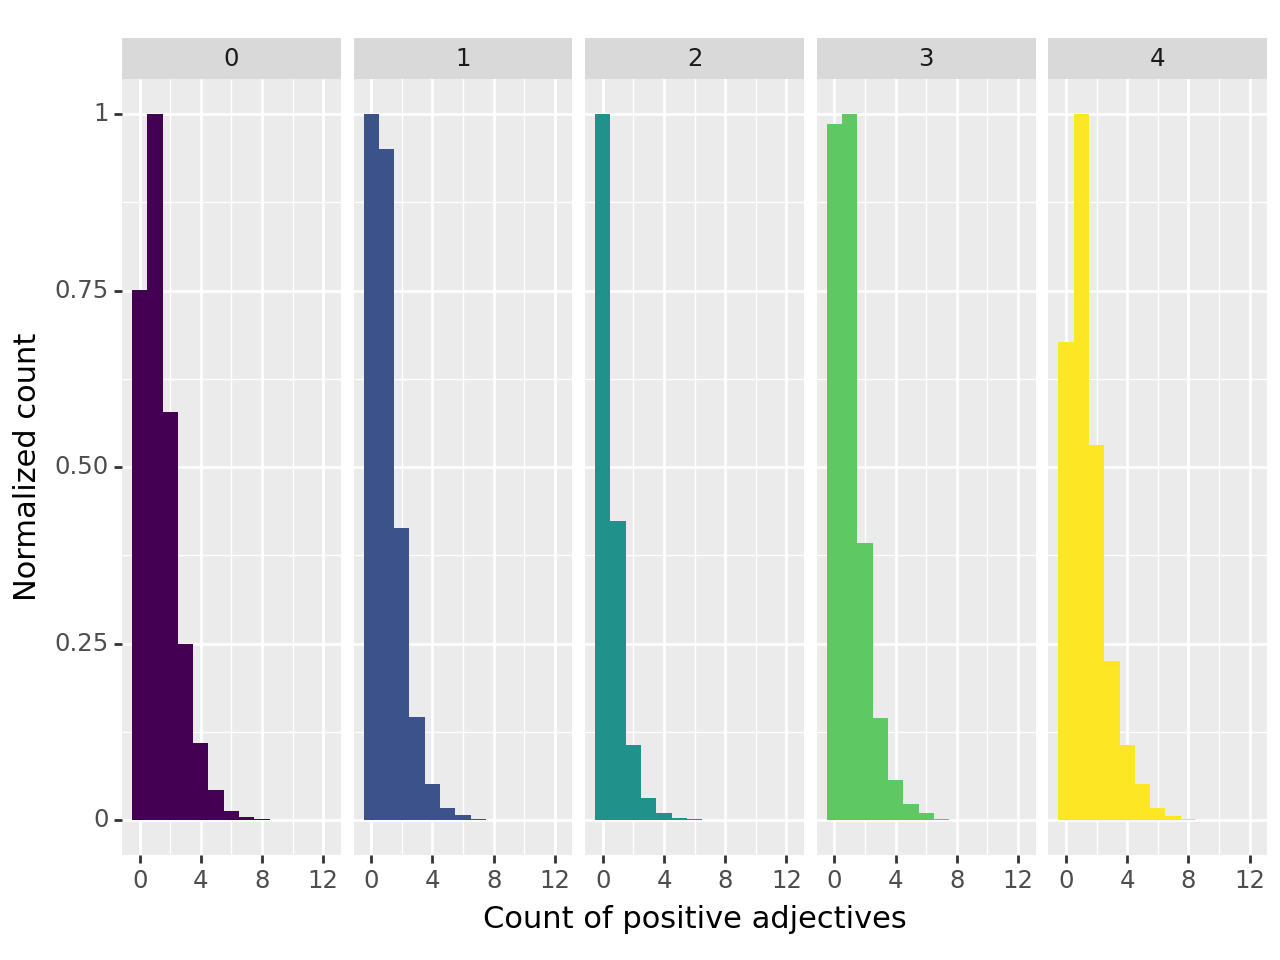

<Figure Size: (640 x 480)>

In [54]:
# Plot normalized distribution of counts of positive adjectives
# Group by sentiment
plot_count_hist(train_jjCount, 'Count of positive adjectives')

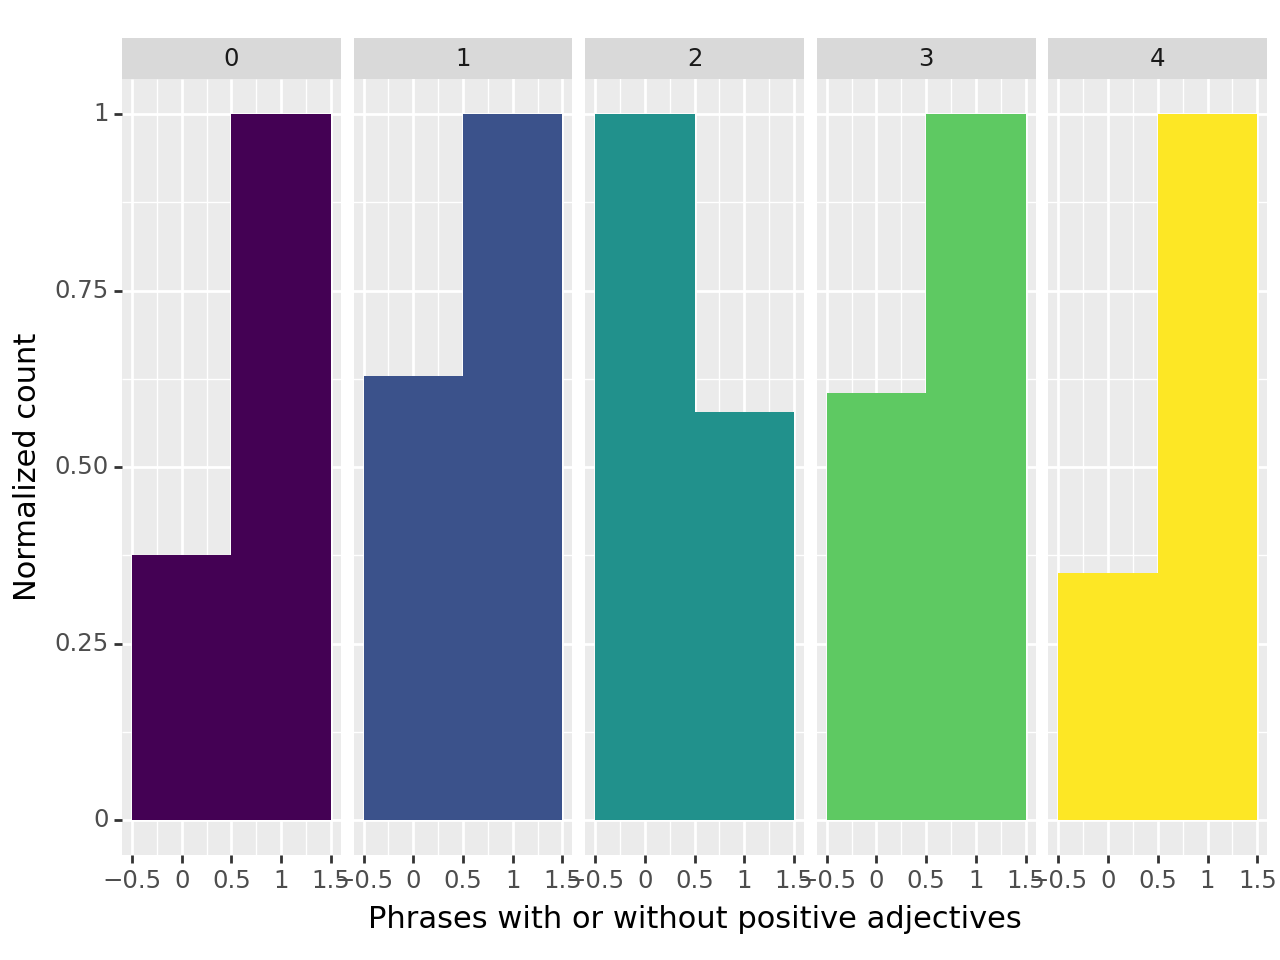

<Figure Size: (640 x 480)>

In [55]:
# Plot normalized distribution of counts of phrases with positive adjectives
# Group by sentiment
plot_count_hist(train_jjCount.apply(lambda x: 1 if x > 0 else 0), 'Phrases with or without positive adjectives')

In [56]:
# Comparative and superlative adjectives (JJR, JJS)
train_jjr_jjsCount = train_data['Phrase'].apply(lambda phrase: np.sum(count_pos(phrase, ['JJR','JJS'])))

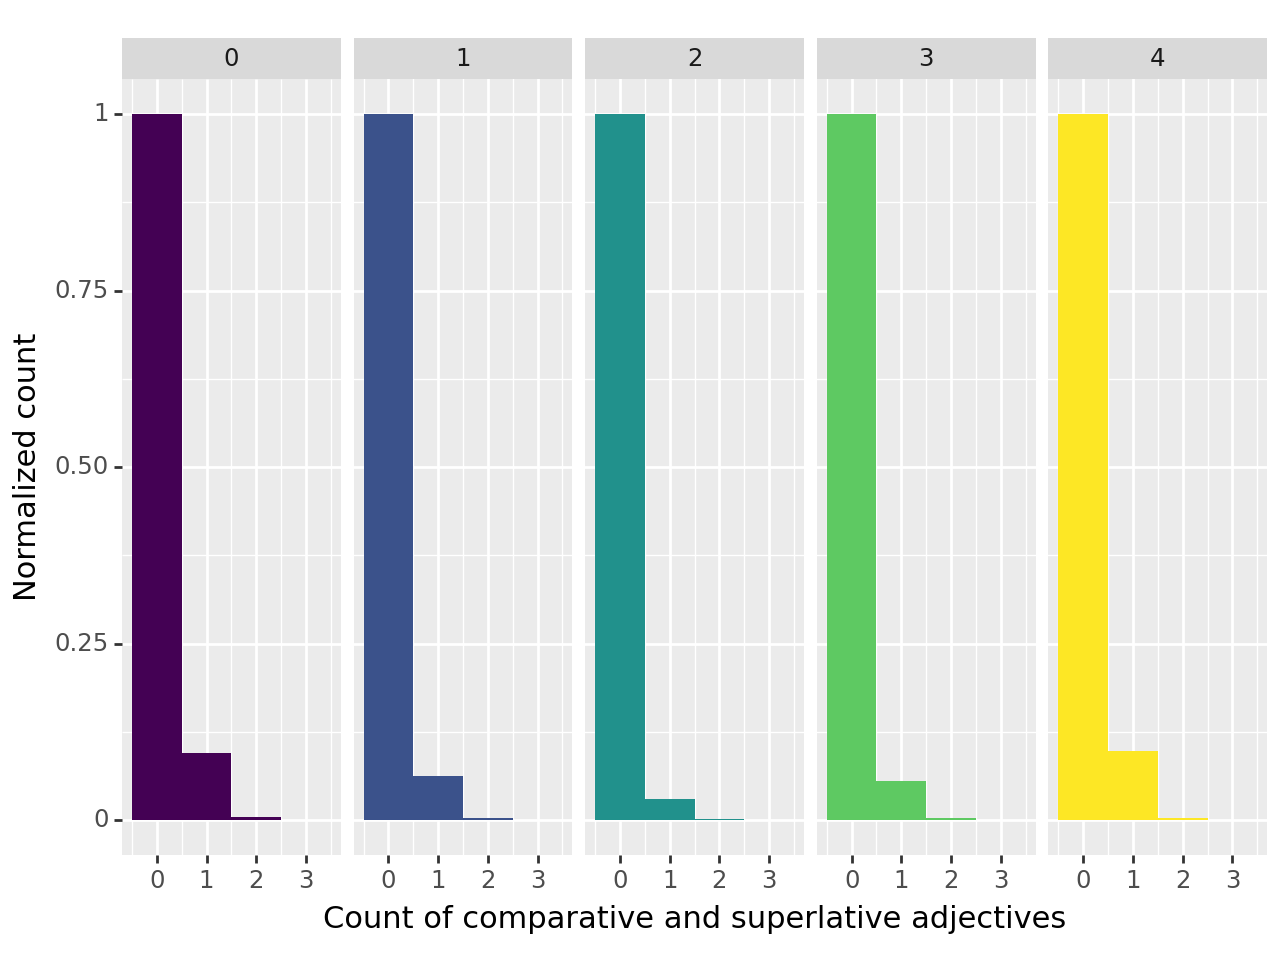

<Figure Size: (640 x 480)>

In [57]:
plot_count_hist(train_jjr_jjsCount, 'Count of comparative and superlative adjectives')

In [58]:
# Positive adverbs (RB)
train_rbCount = train_data['Phrase'].apply(lambda phrase: count_pos(phrase, 'RB')[0])

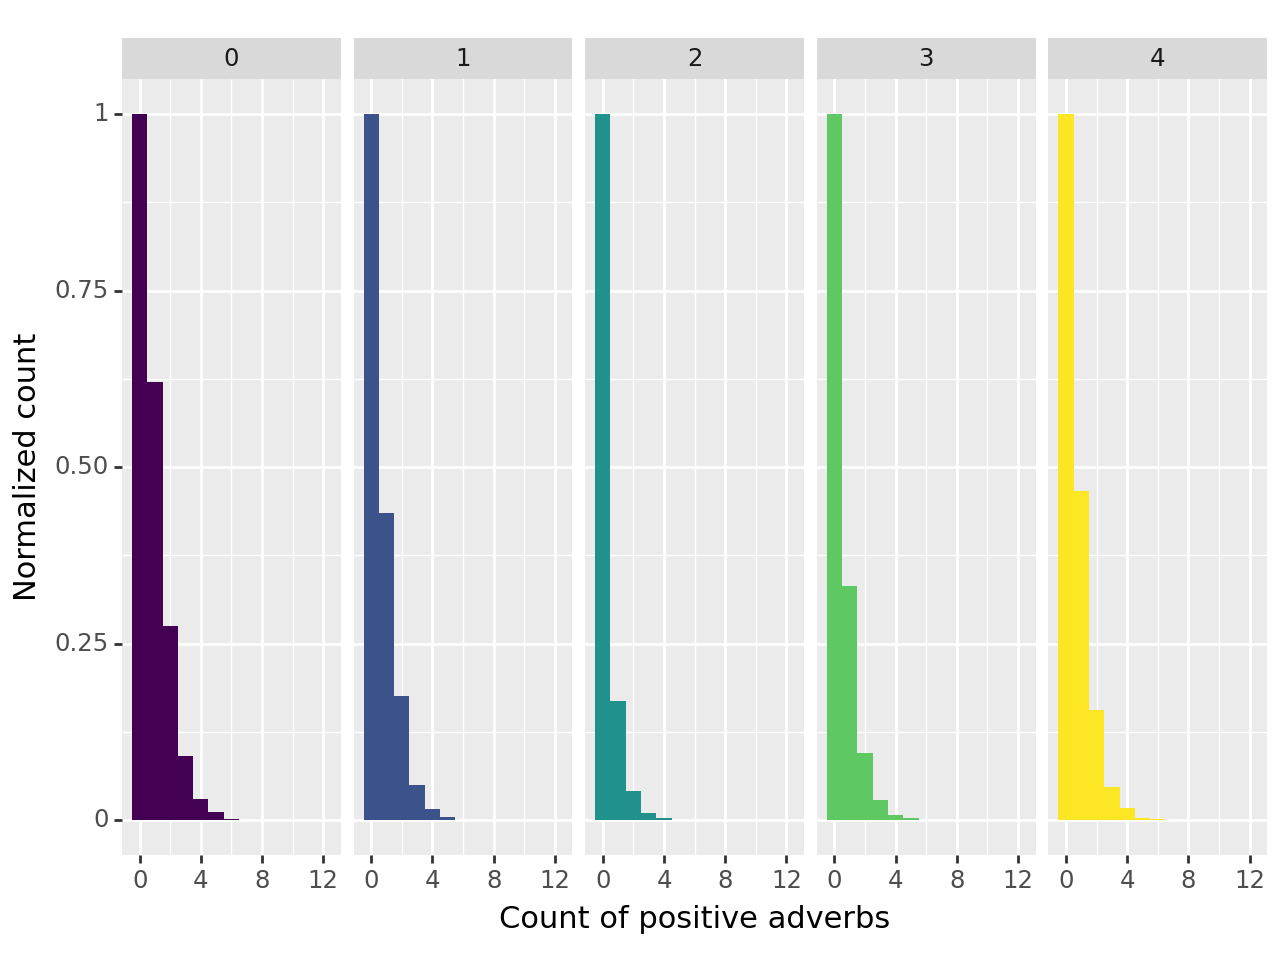

<Figure Size: (640 x 480)>

In [59]:
plot_count_hist(train_rbCount, 'Count of positive adverbs')

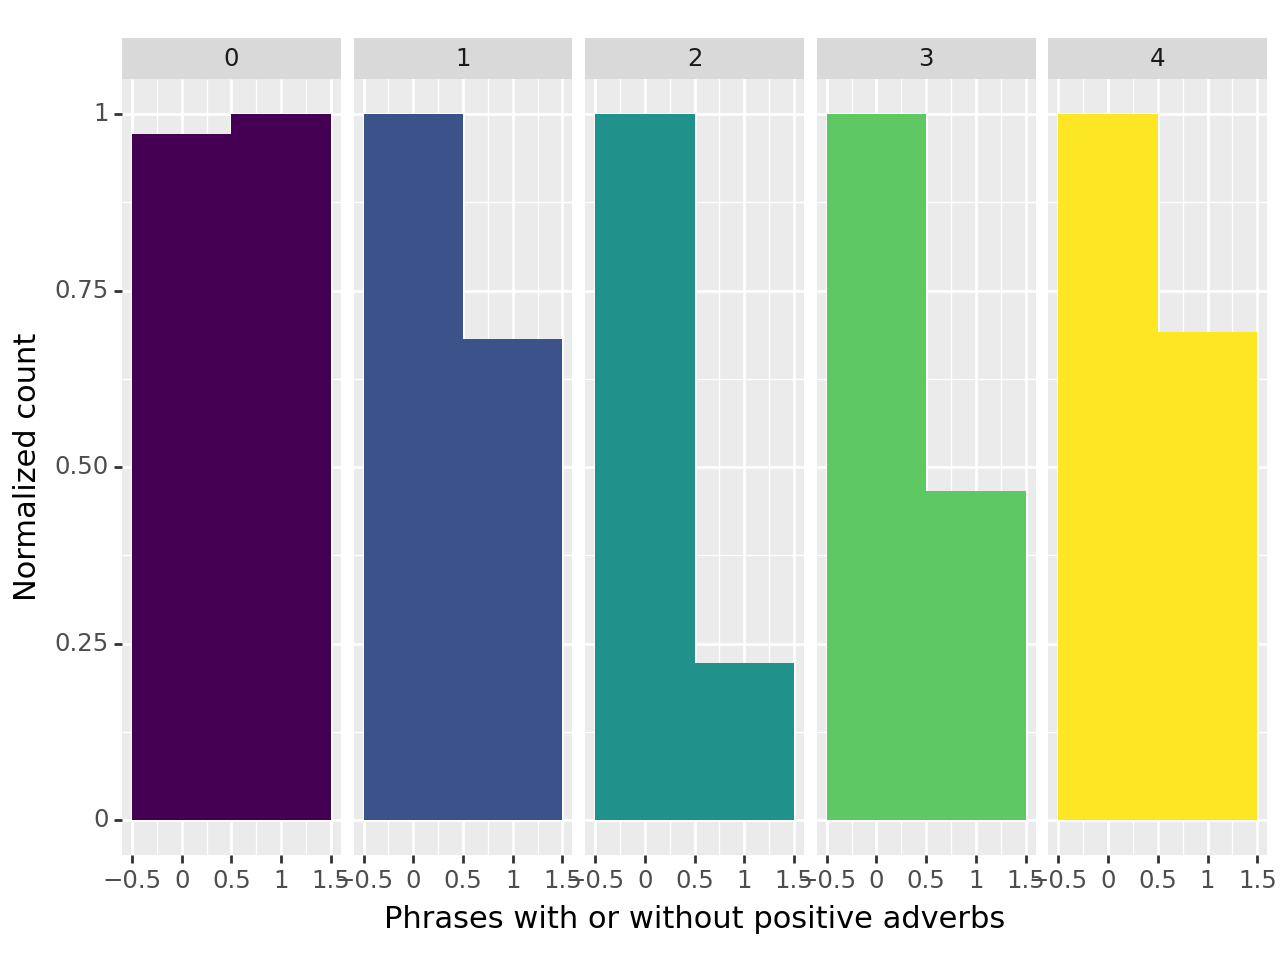

<Figure Size: (640 x 480)>

In [60]:
plot_count_hist(train_rbCount.apply(lambda x: 1 if x > 0 else 0), 'Phrases with or without positive adverbs')

In [61]:
# Comparative and superlative adverbs (RBR, RBS)
train_rbr_rbsCount = train_data['Phrase'].apply(lambda phrase: np.sum(count_pos(phrase, ['RBR','RBS'])))

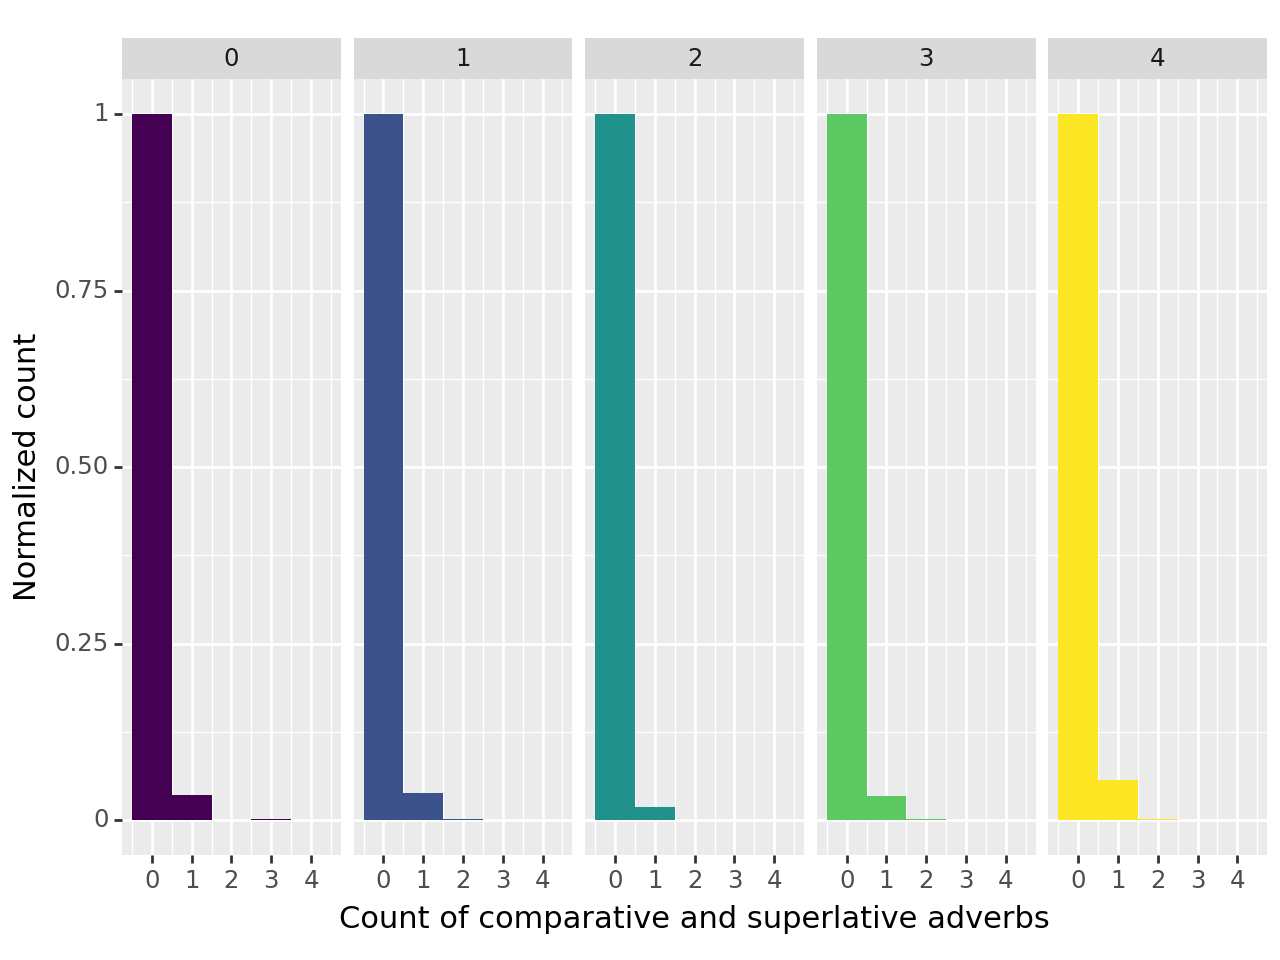

<Figure Size: (640 x 480)>

In [62]:
plot_count_hist(train_rbr_rbsCount, 'Count of comparative and superlative adverbs')

In [63]:
# Singular and plural personal pronouns (NNP, NNPS)
train_nnp_nnpsCount = train_data['Phrase'].apply(lambda phrase: np.sum(count_pos(phrase, ['NNP','NNPS'])))

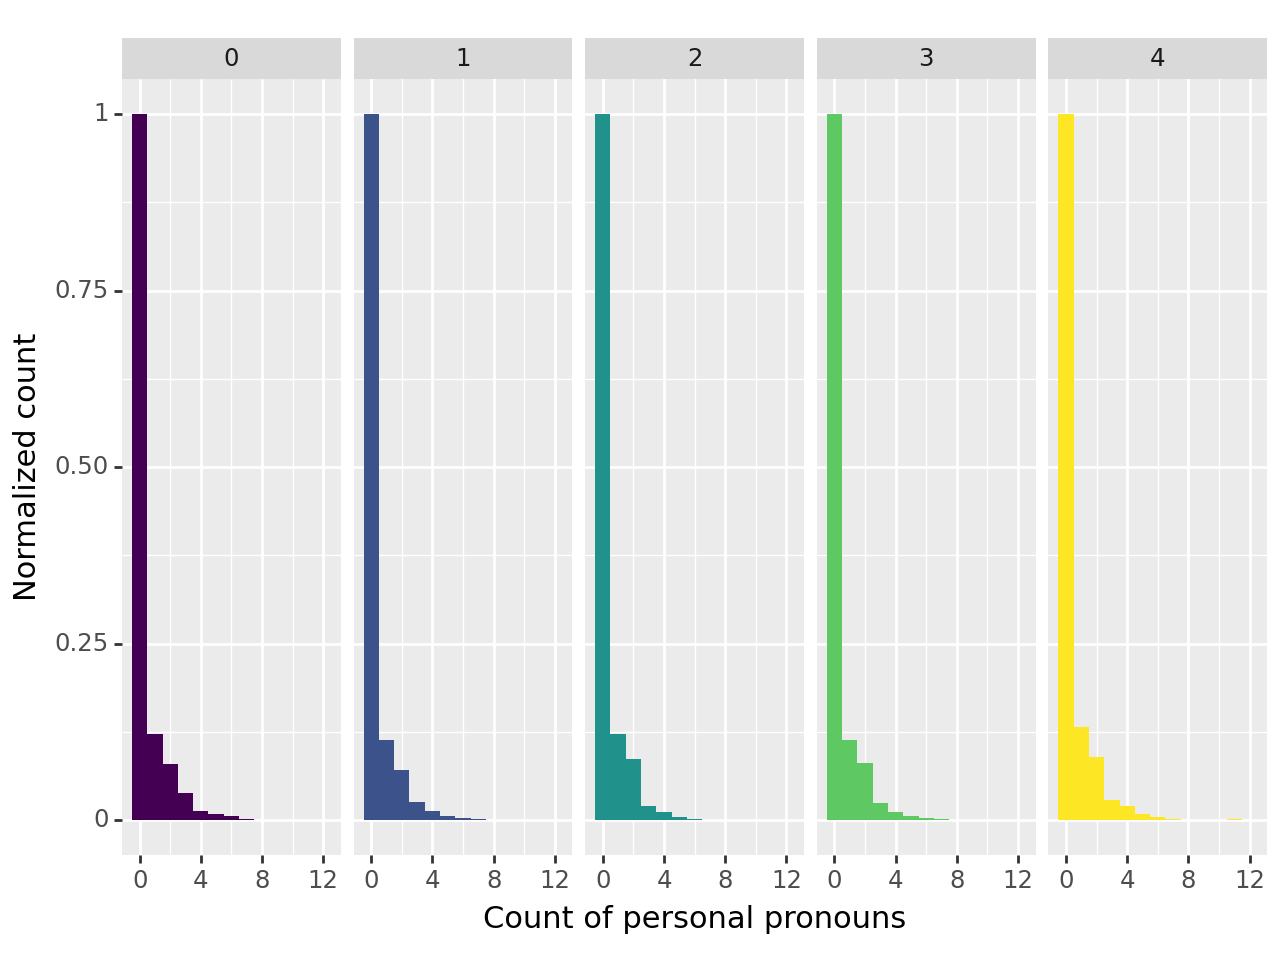

<Figure Size: (640 x 480)>

In [64]:
plot_count_hist(train_nnp_nnpsCount, 'Count of personal pronouns')

In [65]:
train_data['has_adj'] = train_jjCount.apply(lambda x: 1 if x > 0 else 0)
train_data['has_adv'] = train_rbCount.apply(lambda x: 1 if x > 0 else 0)
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,preprocessed_phrase,neg,neu,pos,subj,has_adj,has_adv
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...,0.0,0.843,0.157,0.38125,1,1
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose,0.0,0.805,0.195,0.60000,1,0
2,3,1,A series,2,series,0.0,1.000,0.000,0.00000,0,0
3,4,1,A,2,,0.0,0.000,0.000,0.00000,0,0
4,5,1,series,2,series,0.0,1.000,0.000,0.00000,0,0


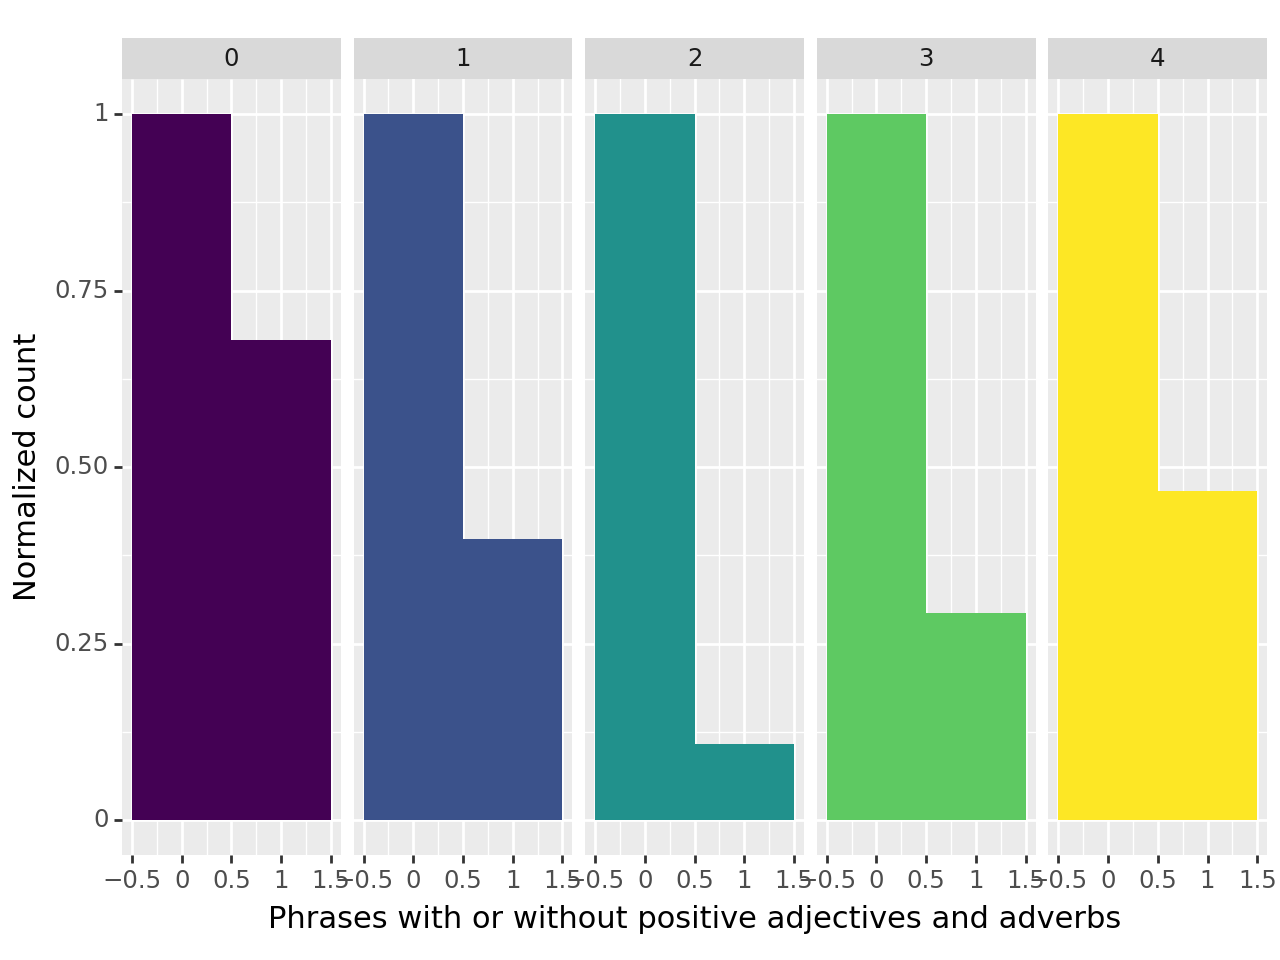

<Figure Size: (640 x 480)>

In [66]:
data = train_data['has_adj'] & train_data['has_adv']
data.name = 'Phrase'
plot_count_hist(data, 'Phrases with or without positive adjectives and adverbs')

Key takeaways:
- Only counts of positive adjectives and adverbs show some differences among sentiments
- Phrases with at least 1 adjective or adverb are more likely to have a sentiment closer to 0 or 4

#### Excluded feature set 1: Phrase/sentence length

Could phrase lengths help predict sentiment? The intuition here is that phrases with sentiments closer to 0 and 4 would have more to say about the movie, and thus would have more words.

In [14]:
# Count the number of words in each phrase
train_phraseLen = train_data['Phrase'].apply(lambda phrase: len([word for word in phrase.split() if word not in punctuation]))
train_phraseLen = pd.concat((train_phraseLen, train_data['Sentiment']), axis=1)
train_phraseLen

,Phrase,Sentiment
0,35,1
1,14,2
2,2,2
3,1,2
4,1,2
...,...,...
156055,2,2
156056,3,1
156057,2,3
156058,1,2


In [15]:
# Same as above, but with sentences only
train_sentenceLen = train_sentences['Phrase'].apply(lambda phrase: len([word for word in phrase.split() if word not in punctuation]))
train_sentenceLen = pd.concat((train_sentenceLen, train_data['Sentiment']), axis=1)
train_sentenceLen

,Phrase,Sentiment
0,35.0,1
63,9.0,4
81,18.0,1
116,23.0,3
156,6.0,1
...,...,...
156055,NaN,2
156056,NaN,1
156057,NaN,3
156058,NaN,2


Text(0, 0.5, 'Phrase length')

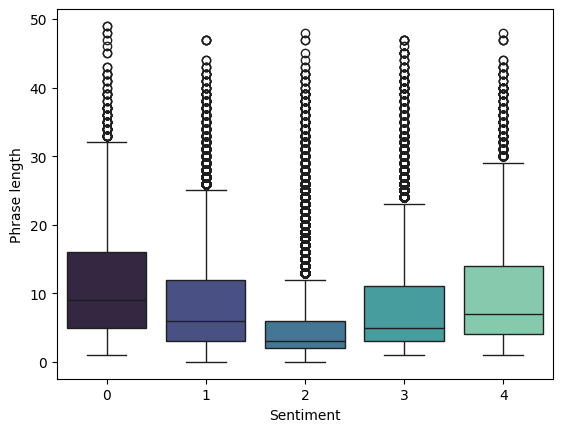

In [16]:
# Plot distribution of phrase lengths for each sentiment
sns.boxplot(train_phraseLen, x='Sentiment', y='Phrase', palette='mako')
plt.ylabel('Phrase length')

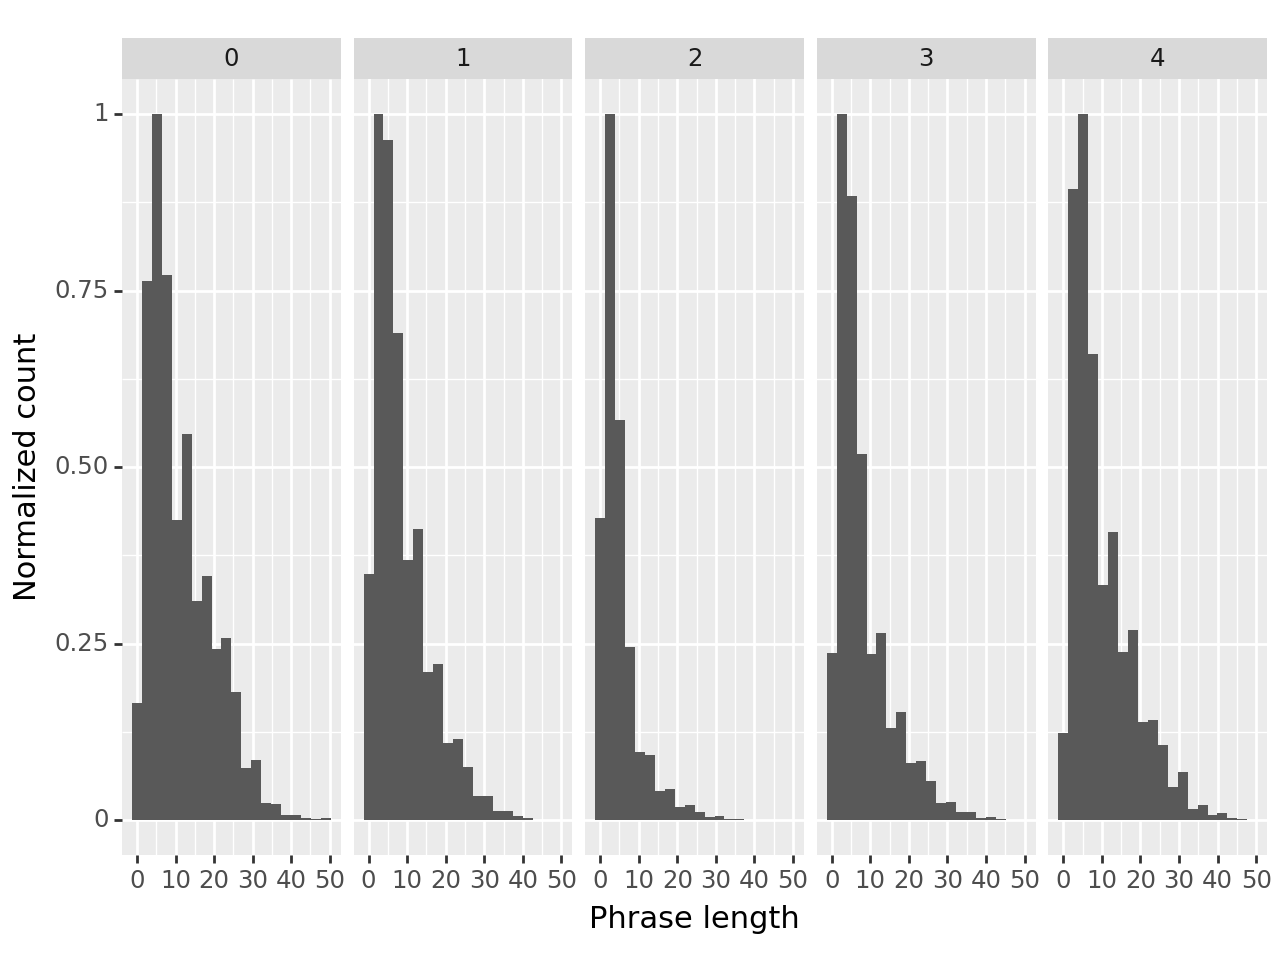

<Figure Size: (640 x 480)>

In [18]:
# Plot normalized distribution of phrase lengths
# Grouped by sentiment
p = p9.ggplot(data=train_phraseLen,
              mapping=p9.aes(x='Phrase', y=p9.after_stat('ncount'))) +\
p9.geom_histogram(bins=20) +\
p9.facet_wrap(facets='Sentiment', ncol=5) +\
p9.labs(x='Phrase length', y='Normalized count')

p

C:\Users\17573\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\17573\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\17573\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Text(0, 0.5, 'Sentence length')

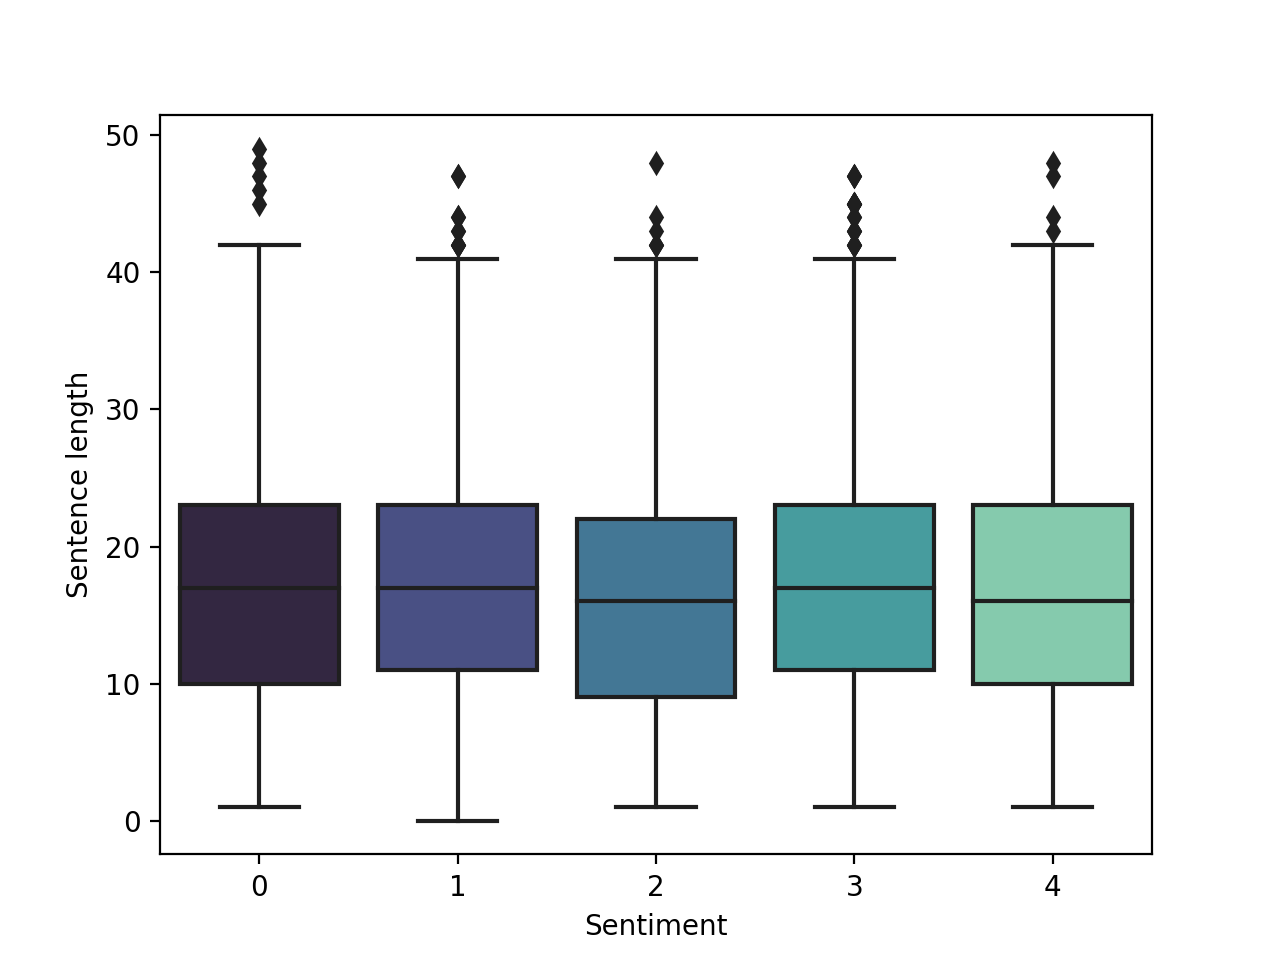

In [135]:
# Now with sentences only
sns.boxplot(train_sentenceLen, x='Sentiment', y='Phrase', palette='mako')
plt.ylabel('Sentence length')

/home/cxiong/.local/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 147531 rows containing non-finite values.


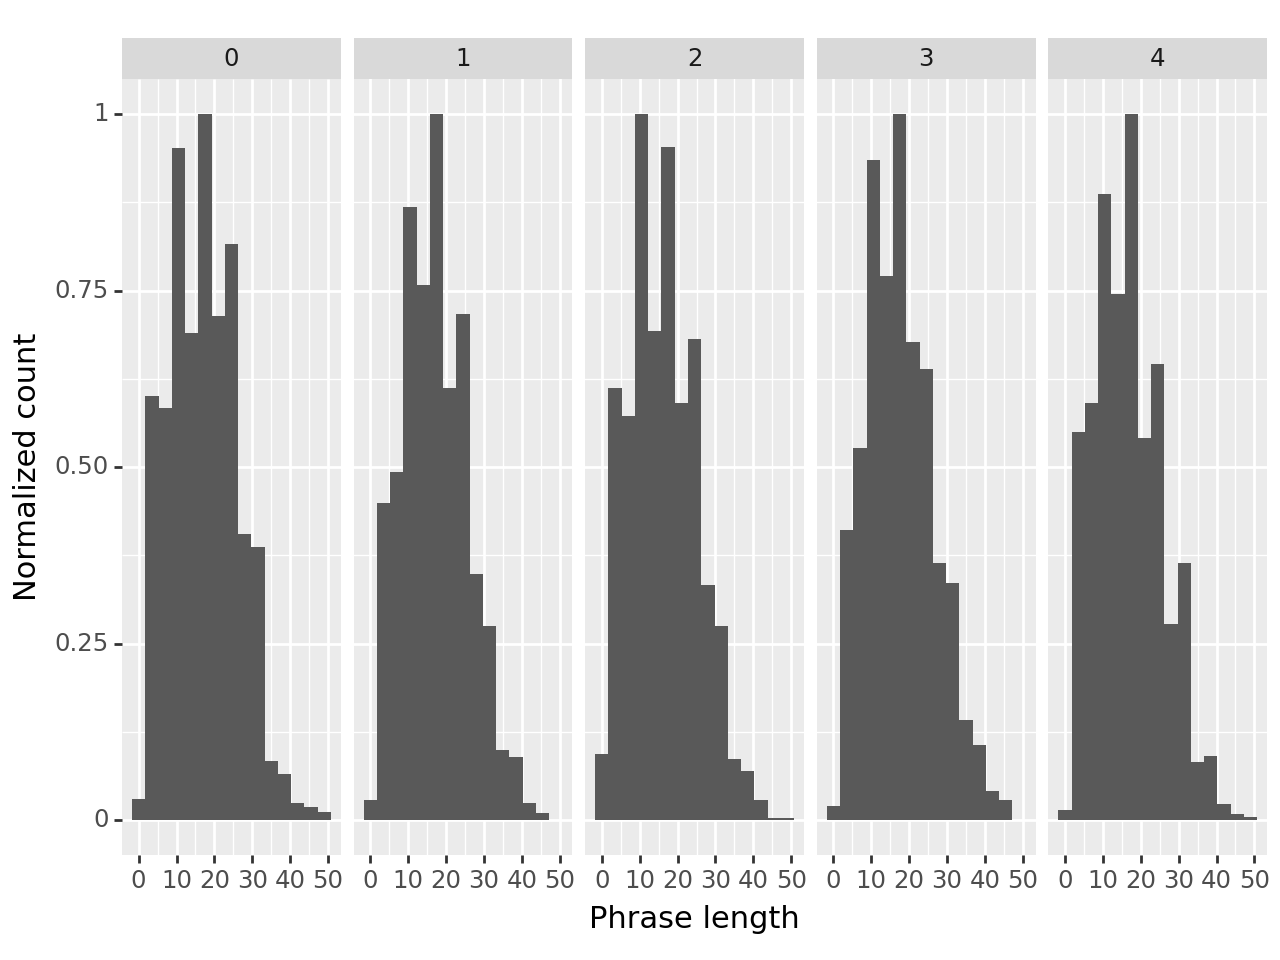

<Figure Size: (640 x 480)>

In [19]:
p = p9.ggplot(data=train_sentenceLen,
              mapping=p9.aes(x='Phrase', y=p9.after_stat('ncount'))) +\
p9.geom_histogram(bins=15) +\
p9.facet_wrap(facets='Sentiment', ncol=5) +\
p9.labs(x='Phrase length', y='Normalized count')

p

There's some difference in lengths across sentiments for all unique phrases, but little to no differences for unique sentences. This can be explained by how this dataset was created.

In our dataset, a single unique sentence has many derived phrases with their own sentiment scores. As seen early in this notebook, this resulted in a dramatic proportional increase in phrases with the sentiment score of 2 compared to the other scores, which are also phrases shorter than the sentence they derived from.

As a feature, phrase lengths would be able to help models take advantage of this fact, but we believe it would be better for our model to focus on the greater challenge of being able to accurately predict sentiments for the full sentences. Thus, phrase lengths will not be included as features for our model.

#### Excluded feature set 2: Counts of !, ?, and .

Exclamation marks and question marks are expressive, and would be used to express strong emotions. Furthermore, in when typing, some people normally leave out periods, but only use them when they want to emphasize something. If this is true, sentiments closer to 0 and 4 may have more exclamation points, question marks, and periods.

In [156]:
train_data['Phrase'].apply(lambda phrase: phrase.count('!')).value_counts()

Phrase
0    155812
1       248
Name: count, dtype: int64

In [157]:
train_data['Phrase'].apply(lambda phrase: phrase.count('?')).value_counts()

Phrase
0    155672
1       368
2        20
Name: count, dtype: int64

It appears that question marks and exclamation points in our training dataset are rare, so they should not be used as features.

In [67]:
train_data['Phrase'].apply(lambda phrase: phrase.count('.')).value_counts().sort_index()

Phrase
0     136368
1      17353
2        442
3       1132
4        665
5          6
6         63
7         23
9          4
12         4
Name: count, dtype: int64

<Axes: xlabel='Sentiment', ylabel='Phrase'>

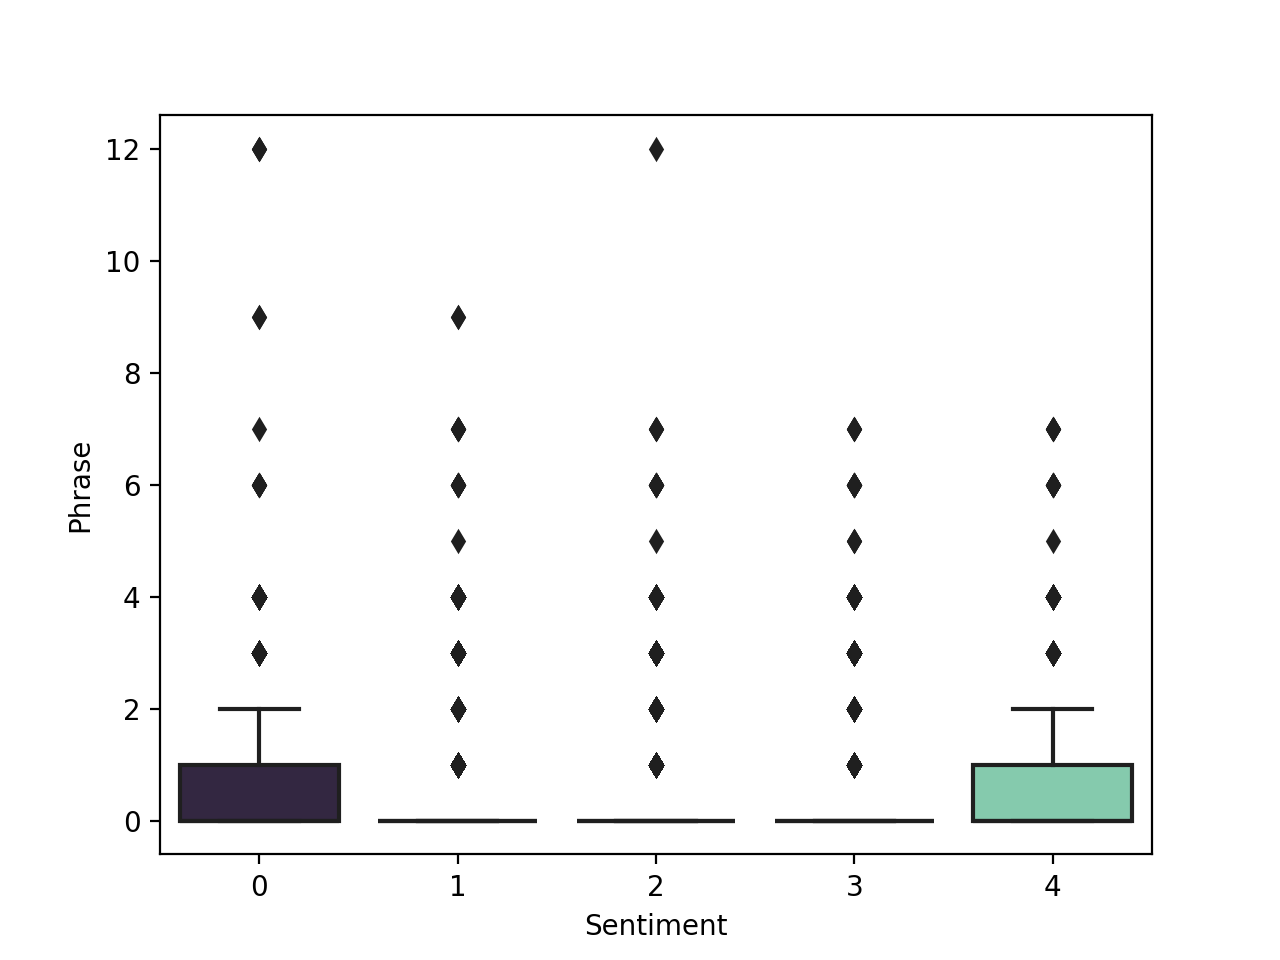

In [68]:
# Plot distribution of period counts by sentiments
sns.boxplot(x=train_data['Sentiment'], 
            y=train_data['Phrase'].apply(lambda phrase: phrase.count('.')), 
            palette='mako')

There is more variation in the distribution of period counts, but the differences are too small to be of use.

#### Create X and y

In [16]:
X = np.hstack((train_data[['neg', 'neu', 'pos', 'subj', 'has_adj', 'has_adv']], train_tfidfFeatures.toarray()))
X

array([[0.   , 0.843, 0.157, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.805, 0.195, ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [17]:
y = train_data['Sentiment']
y

0         1
1         2
2         2
3         2
4         2
         ..
156055    2
156056    1
156057    3
156058    2
156059    2
Name: Sentiment, Length: 156060, dtype: int64

### Evaluating naive Bayes and logistic regression models

#### Train models and evaluate

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

In [25]:
# Train naive Bayes model
nb = MultinomialNB()
nb.fit(Xtrain, ytrain)

MultinomialNB()

In [26]:
# Train logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(Xtrain, ytrain)

LogisticRegression(max_iter=1000)

In [27]:
# Get accuracy scores using the training and testing (validation) data
# Naive Bayes
print("Training score:", nb.score(Xtrain, ytrain))
print("Testing score:", nb.score(Xtest, ytest))

Training score: 0.6412117134435473
Testing score: 0.6058887607330514


In [28]:
# Logistic regression
print("Training score:", lr.score(Xtrain, ytrain))
print("Testing score:", lr.score(Xtest, ytest))

Training score: 0.6907839933358965
Testing score: 0.6411316160451108


In [29]:
# Naive bayes
nb_ypred = nb.predict(X)
print(classification_report(y, nb_ypred))

              precision    recall  f1-score   support

           0       0.78      0.05      0.09      7072
           1       0.57      0.38      0.46     27273
           2       0.66      0.89      0.76     79582
           3       0.56      0.52      0.54     32927
           4       0.79      0.06      0.11      9206

    accuracy                           0.63    156060
   macro avg       0.67      0.38      0.39    156060
weighted avg       0.64      0.63      0.59    156060



In [30]:
# Logistic regression
lr_ypred = lr.predict(X)
print(classification_report(y, lr_ypred))

              precision    recall  f1-score   support

           0       0.69      0.27      0.39      7072
           1       0.61      0.49      0.54     27273
           2       0.72      0.88      0.79     79582
           3       0.62      0.55      0.58     32927
           4       0.68      0.34      0.45      9206

    accuracy                           0.68    156060
   macro avg       0.66      0.51      0.55    156060
weighted avg       0.67      0.68      0.66    156060



In [31]:
# Rows = actual values
# Columns = predicted values
print(confusion_matrix(y, nb_ypred))

[[  326  3837  2699   207     3]
 [   73 10342 15694  1158     6]
 [   18  3315 70693  5530    26]
 [    0   564 15184 17072   107]
 [    0    69  2203  6402   532]]


In [61]:
print(confusion_matrix(y, lr_ypred))

[[ 2109  3423  1383   139    18]
 [  694 13836 11769   925    49]
 [  177  4305 69836  5099   165]
 [   20   796 12365 18578  1168]
 [    3   100  1085  4781  3237]]


The performance of the two models varied in different areas, though the logistic regression model had a better overall performance compared to the naive Bayes model.

In both models, the sentiment score of 2 had (relatively) good precision and recall, and the models' abilities to predict phrases to have the score of 2 were that accurate. Recall was particularly worse for sentiment scores of 0, 1, 3, and 4. That is, the models' predictions of those scores tended to be correct, but they still had trouble detecting phrases with those scores. In particular, the most glaring issue with the naive Bayes model is its ability to predict sentiment scores of 0 and 4. In fact, it quite rarely makes those predictions, and tends to predict phrases with scores of 0 and 4 as 1 and 3, respectively, hence the extremely low recall scores for 0 and 4.

From looking at the confusion matrices, we can see that both models tend to predict sentiment scores of...
- 0 as 1 (2,109 correct predictions of 0 vs. 3,424 incorrectly predicted as 1 in the logistic regression model)
- 1 as 2 (13,836 of 1 vs. 11,769 as 2)
- 3 as 2 (18,578 of 3 vs. 12,365 as 2)
- 4 as 3 (3,237 of 4 vs. 4,781 as 3)

Some of these problems are removed in the evaluation below, where instead of having 5 possible sentiment scores, we only have "negative," "neutral," and "positive" labels.

In [32]:
def simplify_labels(label):
    if (label == 0) or (label == 1):
        return 'negative'
    elif (label == 2):
        return 'neutral'
    elif (label == 3) or (label == 4):
        return 'positive'
    else:
        print("Invalid label", label)
        raise Exception

In [33]:
print(classification_report(pd.Series(y).apply(simplify_labels), 
                            pd.Series(nb_ypred).apply(simplify_labels)))

              precision    recall  f1-score   support

    negative       0.79      0.42      0.55     34345
     neutral       0.66      0.89      0.76     79582
    positive       0.78      0.57      0.66     42133

    accuracy                           0.70    156060
   macro avg       0.74      0.63      0.66    156060
weighted avg       0.72      0.70      0.69    156060



In [34]:
print(classification_report(pd.Series(y).apply(simplify_labels), 
                            pd.Series(lr_ypred).apply(simplify_labels)))

              precision    recall  f1-score   support

    negative       0.78      0.57      0.66     34345
     neutral       0.72      0.88      0.79     79582
    positive       0.81      0.65      0.72     42133

    accuracy                           0.75    156060
   macro avg       0.77      0.70      0.72    156060
weighted avg       0.76      0.75      0.74    156060



In [35]:
print(confusion_matrix(pd.Series(y).apply(simplify_labels), 
                       pd.Series(nb_ypred).apply(simplify_labels)))

[[14578 18393  1374]
 [ 3333 70693  5556]
 [  633 17387 24113]]


In [36]:
print(confusion_matrix(pd.Series(y).apply(simplify_labels), 
                       pd.Series(lr_ypred).apply(simplify_labels)))

[[19528 13648  1169]
 [ 4509 69698  5375]
 [  929 13924 27280]]


The naive Bayes model's performance appear much better now that its most glaring problem is removed, though the logistic regression model still outperforms it overall.

#### KFold validation

In [21]:
def DoKFold(X, y, model):
    train_scores = []
    test_scores = []

    kfold = StratifiedKFold(shuffle=True)
    for train_i, test_i in kfold.split(X, y):
        # Fit model with training data
        model.fit(X[train_i], y[train_i])

        # Get scores using training and testing (validation) data
        tr = model.score(X[train_i], y[train_i])
        te = model.score(X[test_i], y[test_i])

        # Track scores
        train_scores.append(tr)
        test_scores.append(te)
        print("Training score:", tr, "\tTesting score:", te)

    print("\nAverage training score:", np.mean(train_scores))
    print("Average testing score:", np.mean(test_scores))

In [24]:
# Naive Bayes
DoKFold(X, y, MultinomialNB())

Training score: 0.6419165705497886 	Testing score: 0.6045751633986928
Training score: 0.6414520056388568 	Testing score: 0.60560041009868
Training score: 0.6422209406638473 	Testing score: 0.6066897347174164
Training score: 0.6419165705497886 	Testing score: 0.6063052672049212
Training score: 0.6403306420607459 	Testing score: 0.6115596565423556

Average training score: 0.6415673458926054
Average testing score: 0.6069460463924132


In [19]:
# Logistic regression
DoKFold(X, y, LogisticRegression(max_iter=1000))

Training score: 0.6901672433679354 	Testing score: 0.642477252338844
Training score: 0.6916810841983853 	Testing score: 0.6412597718826093
Training score: 0.6920255030116622 	Testing score: 0.6412597718826093
Training score: 0.6906878764577726 	Testing score: 0.6414840445982315
Training score: 0.6915128796616686 	Testing score: 0.6409393822888633

Average training score: 0.6912149173394849
Average testing score: 0.6414840445982314


There is a very consistent pattern of slight overfitting in both the naive Bayes and logistic regression models.

### Feature evaluation

We will be training new models with and without certain features to evaluate their usefulness to performance. Naive bayes models will be trained to save on time.

On average, our naive Bayes model scored a 0.642 on the training data and a 0.607 on the testing (validation) data.

In [19]:
model = MultinomialNB()

#### TF-IDF vectors

Our TF-IDF features perform almost just as well on their own.

In [22]:
# Without TF-IDF
DoKFold(X[:,:6], y, model)

Training score: 0.5262559272074843 	Testing score: 0.528963219274638
Training score: 0.5270008330129438 	Testing score: 0.527201076509035
Training score: 0.5273452518262207 	Testing score: 0.5252146610278098
Training score: 0.5273612713059079 	Testing score: 0.5255670895809305
Training score: 0.5266884531590414 	Testing score: 0.5273933102652826

Average training score: 0.5269303473023197
Average testing score: 0.5268678713315392


In [23]:
# TF-IDF only
DoKFold(X[:,6:], y, model)

Training score: 0.6302864282968089 	Testing score: 0.5867294630270409
Training score: 0.631383762655389 	Testing score: 0.5867615019864155
Training score: 0.6295895809304114 	Testing score: 0.5930731769832116
Training score: 0.6285002563116749 	Testing score: 0.5910226835832372
Training score: 0.6298218633858772 	Testing score: 0.5868255799051647

Average training score: 0.6299163783160322
Average testing score: 0.588882481097014


#### Polarity scores

Polarity gives a very small amount of contribution.

In [25]:
# Without polarity
DoKFold(X[:,3:], y, model)

Training score: 0.6342592592592593 	Testing score: 0.5936498782519544
Training score: 0.6347398436498782 	Testing score: 0.5955081378956811
Training score: 0.6341631423811355 	Testing score: 0.5964052287581699
Training score: 0.6350842624631552 	Testing score: 0.5936498782519544
Training score: 0.6348760092272203 	Testing score: 0.5956683326925541

Average training score: 0.6346245033961297
Average testing score: 0.5949762911700629


In [27]:
# Polarity only
DoKFold(X[:,:3], y, model)

Training score: 0.5138328207099834 	Testing score: 0.5132961681404588
Training score: 0.5141532103037293 	Testing score: 0.5137126746123286
Training score: 0.5141211713443548 	Testing score: 0.513840830449827
Training score: 0.5140570934256056 	Testing score: 0.5140971421248238
Training score: 0.5134884018967064 	Testing score: 0.5146738433935666

Average training score: 0.5139305395360758
Average testing score: 0.5139241317442009


#### Subjectivity

Subjectivity doesn't seem to add much to the model. It gives a smaller amount of contribution.

In [28]:
# Without subjectivity scores
DoKFold(np.hstack((train_data[['neg', 'neu', 'pos', 'has_adj', 'has_adv']], train_tfidfFeatures.toarray())),
        y, model)

Training score: 0.6412597718826093 	Testing score: 0.6035178777393311
Training score: 0.6403386518005895 	Testing score: 0.6023644752018454
Training score: 0.6412277329232347 	Testing score: 0.6085479943611432
Training score: 0.6403226323209023 	Testing score: 0.603678072536204
Training score: 0.6413398692810458 	Testing score: 0.6063373061642958

Average training score: 0.6408977316416762
Average testing score: 0.6048891452005639


In [30]:
# Subjectivity scores only
DoKFold(X[:,4].reshape(-1,1), y, model)

Training score: 0.5099480968858131 	Testing score: 0.5099320774061259
Training score: 0.5099480968858131 	Testing score: 0.5099320774061259
Training score: 0.5099480968858131 	Testing score: 0.5099320774061259
Training score: 0.5099400871459695 	Testing score: 0.5099641163655004
Training score: 0.5099400871459695 	Testing score: 0.5099641163655004

Average training score: 0.5099448929898756
Average testing score: 0.5099448929898757


#### Parts of speech (adjectives and adverbs)

Our adjective and adverb counts give an even smaller amount of contribution.

In [31]:
# Without POS counts
DoKFold(np.hstack((train_data[['neg', 'neu', 'pos', 'subj']], train_tfidfFeatures.toarray())),
        y, model)

Training score: 0.6384083044982699 	Testing score: 0.5983275663206459
Training score: 0.6384163142381135 	Testing score: 0.6018518518518519
Training score: 0.6371587850826606 	Testing score: 0.604479046520569
Training score: 0.6374070870178137 	Testing score: 0.5997693194925029
Training score: 0.6378075740099961 	Testing score: 0.6048635140330642

Average training score: 0.6378396129693708
Average testing score: 0.6018582596437267


In [32]:
# POS counts only
DoKFold(X[:,5:6], y, model)

Training score: 0.5099480968858131 	Testing score: 0.5099320774061259
Training score: 0.5099480968858131 	Testing score: 0.5099320774061259
Training score: 0.5099480968858131 	Testing score: 0.5099320774061259
Training score: 0.5099400871459695 	Testing score: 0.5099641163655004
Training score: 0.5099400871459695 	Testing score: 0.5099641163655004

Average training score: 0.5099448929898756
Average testing score: 0.5099448929898757


#### Conclusion

Our TF-IDF vectors are our sole best set of features for predicting the sentiment scores of phrases, while the other features offered little to no contribution to our model.

### Final predictions

In [38]:
# TF-IDF vectors
test_data['preprocessed_phrase'] = test_data['Phrase'].apply(preprocess_phrase)
test_sentences = test_data.drop_duplicates('SentenceId', keep='first')
test_tfidfFeatures = vectorizer.transform(test_data['preprocessed_phrase'])

# Polarity scores
test_polarityScores = test_data['Phrase'].apply(lambda phrase: analyzer.polarity_scores(phrase))
test_data['neg'] = test_polarityScores.apply(lambda scores: scores['neg'])
test_data['neu'] = test_polarityScores.apply(lambda scores: scores['neu'])
test_data['pos'] = test_polarityScores.apply(lambda scores: scores['pos'])

# Subjectivity scores
test_data['subj'] = test_data['Phrase'].apply(lambda phrase: TextBlob(phrase).subjectivity)

# POS counts
test_jjCount = test_data['Phrase'].apply(lambda phrase: count_pos(phrase, 'JJ')[0])
test_rbCount = test_data['Phrase'].apply(lambda phrase: count_pos(phrase, 'RB')[0])
test_data['has_adj'] = test_jjCount.apply(lambda x: 1 if x > 0 else 0)
test_data['has_adv'] = test_rbCount.apply(lambda x: 1 if x > 0 else 0)

test_data.head()

,PhraseId,SentenceId,Phrase,preprocessed_phrase,neg,neu,pos,subj,has_adj,has_adv
0,156061,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing mostly routine effort,0.0,0.732,0.268,0.5,1,1
1,156062,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing mostly routine effort,0.0,0.732,0.268,0.5,1,1
2,156063,8545,An,,0.0,1.000,0.000,0.0,0,0
3,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing mostly routine effort,0.0,0.694,0.306,0.5,1,1
4,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing mostly routine,0.0,0.645,0.355,0.5,1,1


In [39]:
features = np.hstack((test_data[['neg', 'neu', 'pos', 'subj', 'has_adj', 'has_adv']], test_tfidfFeatures.toarray()))
features

array([[0.   , 0.732, 0.268, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.732, 0.268, ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [40]:
preds = lr.predict(features)
preds

array([3, 3, 2, ..., 1, 1, 2])

In [42]:
# submission = pd.concat((test_data['PhraseId'], pd.Series(preds)), axis=1)
# submission.columns = ['PhraseId', 'Sentiment']
# submission.to_csv('submission.csv', index=False)